# Coarse supervision

This notebooks explains step-by-step how the custom dataset is build.

In [1]:
import sys
sys.path.append('c:\\Users\\robin\\Documents\\HyperBrain')
sys.path.append('c:\\Users\\robin\\Documents\\HyperBrain\\source')

In [17]:
import os
from source.data_processing.image_reading import read_image
from source.data_processing.transformations import sample_random_affine_matrix
from kornia.geometry.transform import warp_affine
from source.data_processing.cropping import *
from source.data_processing.transformations import *
from source.data_processing.patch_processing import create_match_matrix
from source.data_processing.keypoints import generate_image_grid_coordinates
from source.visualization.image_visualization import *
from torchvision import transforms

#### Read 2 consecutive images

In [3]:
images_directory = "../../data/cyto_downscaled_3344_3904/"
image_names = os.listdir(images_directory)
image_1, image_2 = read_image(
    os.path.join(images_directory, image_names[0])
), read_image(os.path.join(images_directory, image_names[1]))
image_1 = transforms.ToTensor()(image_1)
image_2 = transforms.ToTensor()(image_2)

In [4]:
image_size = image_1.shape[-2:]
image_size

torch.Size([3344, 3904])

Note that these are not the same images!

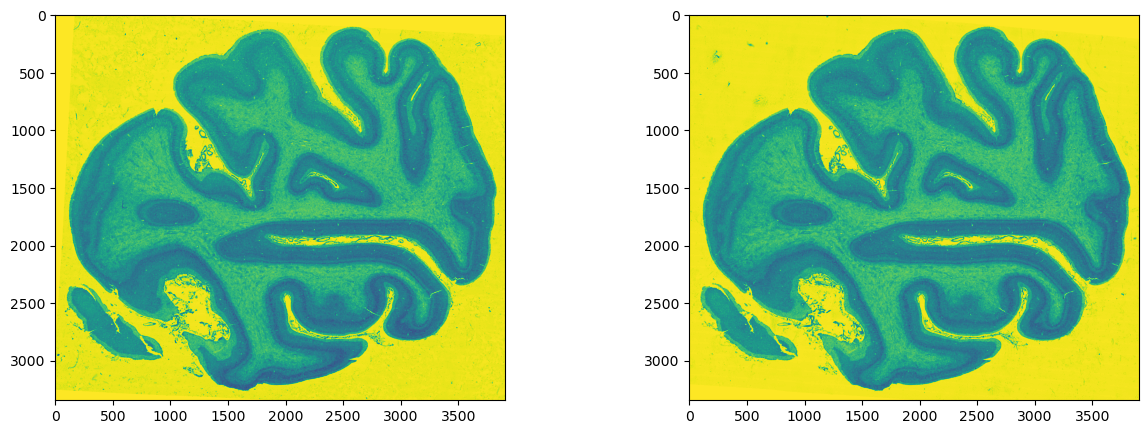

In [5]:
plot_images_in_row([image_1[0], image_2[0]])

#### Transform image 2

Note that this is the same image but one is transformed

In [6]:
transformation_matrix = sample_random_affine_matrix(range_limit=0.2)
image_2_transformed = warp_affine(
    src=image_2.unsqueeze(0), M=transformation_matrix, dsize=image_size, mode="nearest"
)[0]

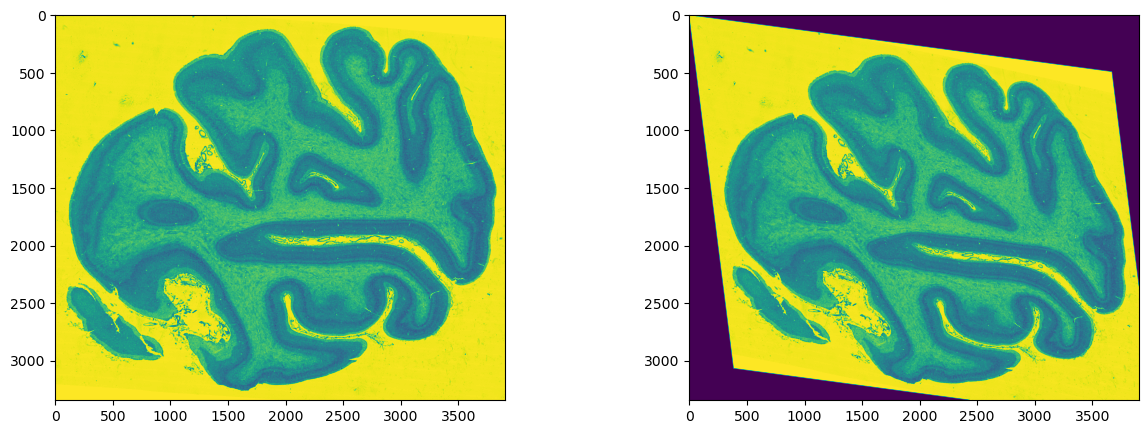

In [7]:
plot_images_in_row([image_2[0], image_2_transformed[0]])

#### Create grid coordinates and a corresponding mapping between image_1 and image_2_transformed

Grid coordinate holds the pixel coordinates, ie grid_coordinates[i,j] = i,j

In [8]:
grid_coordinates = generate_image_grid_coordinates(image_size)
grid_coordinates.shape

torch.Size([3344, 3904, 2])

image_coordinate_mapping holds the mapping from image_1 to image_2_transformed. Can be interpreted as follows: image_coordinate_mapping[i,j] give the coordinate in image_2_transformed of pixel (i,j) in image_1.

In [9]:
image_coordinate_mapping = transform_grid_coordinates(
    grid_coordinates, transformation_matrix[0]
)
image_coordinate_mapping.shape

torch.Size([3344, 3904, 2])

In [12]:
# Where was pixel (42, 42) mapped to?
image_coordinate_mapping[42, 42]

tensor([44.3232, 43.8393])

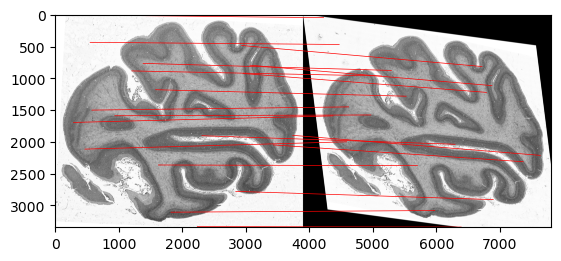

In [10]:
plot_images_with_matches_via_mapping(
    image_1,
    image_2_transformed,
    image_coordinate_mapping,
    number_of_matches=20,
    sample_keypoints_randomly=True,
)

In [15]:
# Sample valid crop positions for image_1 and image_2_transformed
crop_size=640

crop_position_image_1, crop_position_image_2 = sample_crop_coordinates(
    coordinate_mapping=image_coordinate_mapping,
    crop_size=crop_size,
    max_translation_shift=50,
)
crop_position_image_1, crop_position_image_2

((2464, 649), tensor([2372,  893]))

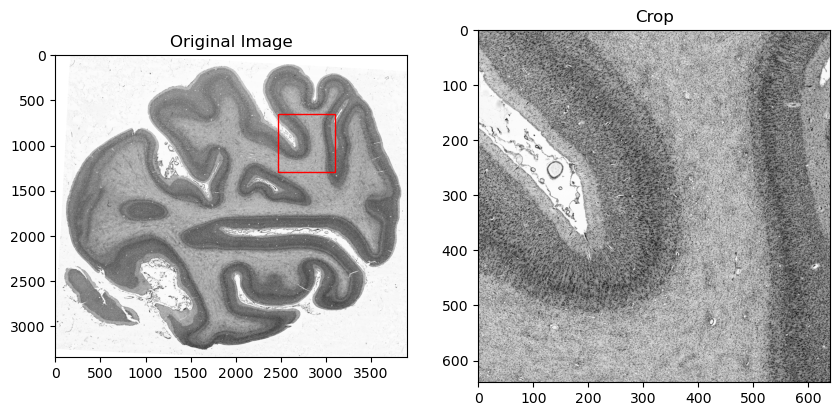

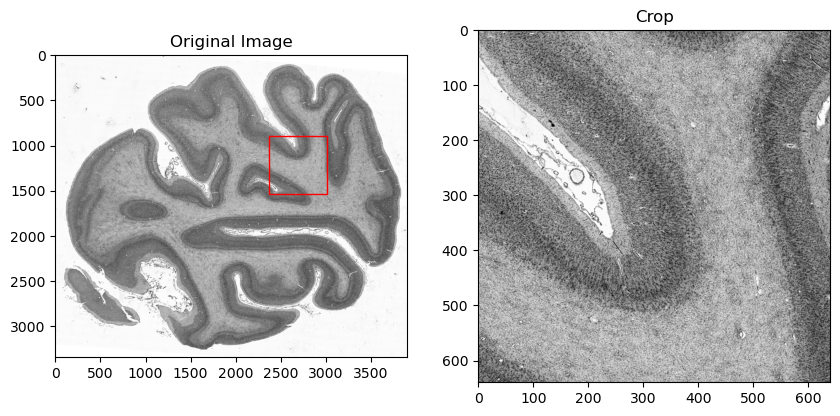

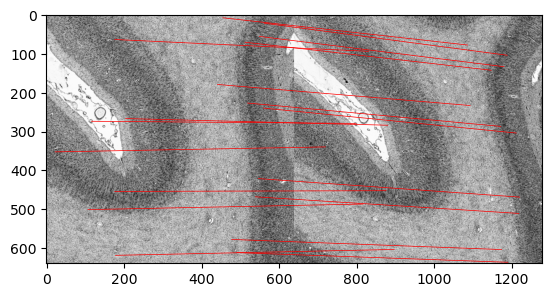

In [23]:
# Crop the images
image_1_crop = crop_image(
    image=image_1, crop_position=crop_position_image_1, crop_size=crop_size
)
image_2_crop = crop_image(
    image=image_2_transformed,
    crop_position=crop_position_image_2,
    crop_size=crop_size,
)

# Generate a mapping between the two crops - interpreted similar to image_coordinate_mapping
crop_coordinate_mapping = create_crop_coordinate_mapping(
    image_coordinate_mapping=image_coordinate_mapping,
    crop_position_image_1=crop_position_image_1,
    crop_position_image_2=crop_position_image_2,
    crop_size=crop_size,
)

plot_image_with_crop(
    original_image=image_1, crop_image=image_1_crop, crop_position=crop_position_image_1
)
plot_image_with_crop(
    original_image=image_2, crop_image=image_2_crop, crop_position=crop_position_image_2
)

plot_images_with_matches_via_mapping(image_1_crop, image_2_crop, crop_coordinate_mapping, number_of_matches=20, sample_keypoints_randomly=True)

In [18]:
# Final step of coarse supervision
# Match matrix can be interpreted as a binary matrix indicating patch matches
# match_matrix[i,j] = 1 if patch i in image_1_crop matches patch j in image_2_crop
match_matrix = create_match_matrix(
    crop_coordinate_mapping=crop_coordinate_mapping,
    crop_size=crop_size,
    patch_size=16,
)
match_matrix.shape

torch.Size([1600, 1600])

In [20]:
match_matrix.sum()  # Number of matches

tensor(1528)

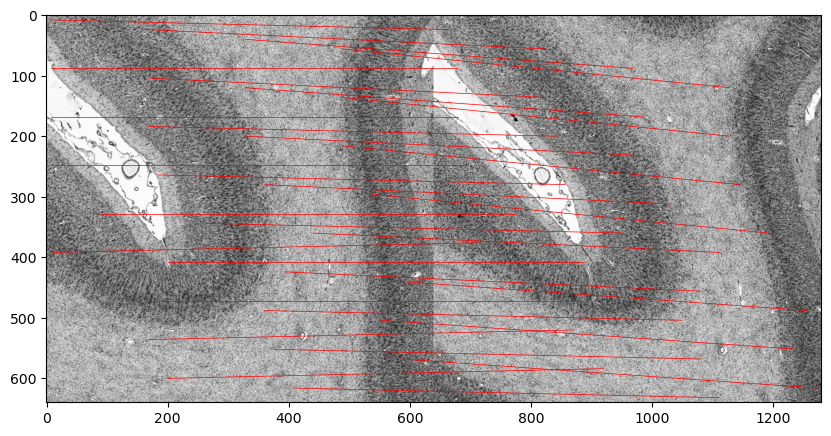

In [21]:
plot_images_with_matches_via_match_matrix(image_1_crop, image_2_crop, match_matrix, visualization_mode="lines")

Darker red patches -> Multiple matches for one patch

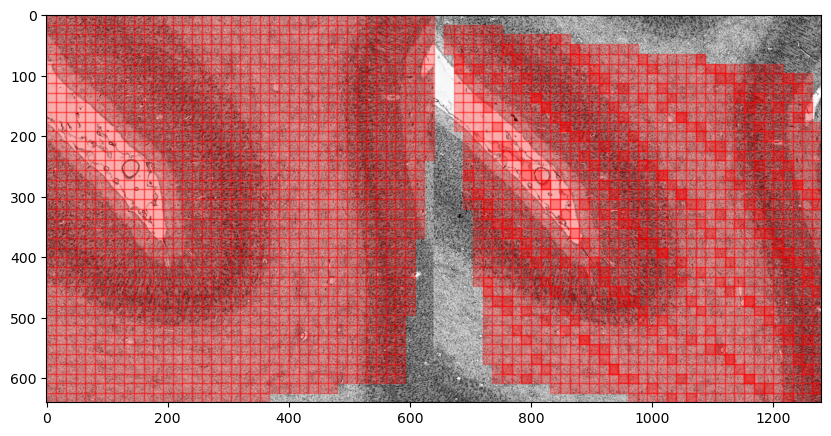

In [22]:
plot_images_with_matches_via_match_matrix(image_1_crop, image_2_crop, match_matrix, visualization_mode="patches")